# Behavioural analysis

## Preparing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/Users/egor/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading the data:

In [3]:
%matplotlib inline
plt.style.use('dark_background')
expName = 'dg'
dataDir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data'))
allSubjDirs = glob.glob(dataDir + '/' + expName + '*')
#print allSubjDirs
ds = pd.DataFrame()
dsCont = pd.DataFrame() # for continuous manual tracking data
for subjDir in allSubjDirs:
    subjDirBasename = os.path.basename(subjDir)
    print subjDirBasename
    subjFilePath = glob.glob(subjDir + '/' + subjDirBasename + '.csv')[0]
    ds = ds.append(pd.read_csv(subjFilePath))
    subjContFilePath = glob.glob(subjDir + '/' + subjDirBasename + '_cont.csv')[0]
    dsCont = dsCont.append(pd.read_csv(subjContFilePath, header=None))
#print ds.head(5)
print ds.shape
print dsCont.shape
print ds.columns

dg_p0_crn-test_s1_r1_2017-01-09_1522
dg_p0_crn-test_s1_r2_2017-01-09_1525
(4, 28)
(4, 1200)
Index([u'expName', u'time', u'participant', u'session', u'run', u'trialN',
       u'dirL', u'dirR', u'vL', u'vR', u'szL', u'szR', u'sfL', u'sfR', u'colL',
       u'colR', u'sat', u'trialT', u'nFrames', u'nNa', u'nf000', u'nf090',
       u'nf180', u'nf270', u'pd000', u'pd090', u'pd180', u'pd270'],
      dtype='object')


Transforming the data set first.

In [4]:
# Measuring velocities in dps:
ds.vR_dps = np.round(ds.vR*.15,1)
ds.vL_dps = np.round(ds.vL*.15,1)
# Measuring sf in cycles per degree:
ds.sfL_cpd = np.round(ds.sfL*34,1)
ds.sfR_cpd = np.round(ds.sfR*34,1)
ds.head(5)

,expName,time,participant,session,run,trialN,dirL,dirR,vL,vR,...,nFrames,nNa,nf000,nf090,nf180,nf270,pd000,pd090,pd180,pd270
0,dg,2017-01-09_1522,0,1,1,1,180,0,6.7,6.7,...,60,636,149,0,415,0,0.124167,0.0,0.345833,0.0
1,dg,2017-01-09_1522,0,1,1,2,0,180,6.7,6.7,...,60,412,320,0,468,0,0.266667,0.0,0.390000,0.0
0,dg,2017-01-09_1525,0,1,2,1,0,180,6.7,6.7,...,60,637,164,0,399,0,0.136667,0.0,0.332500,0.0
1,dg,2017-01-09_1525,0,1,2,2,180,0,6.7,6.7,...,60,772,205,0,223,0,0.170833,0.0,0.185833,0.0


## Behavioural predominance

### Influence of color

### Influence of direction

## Behavioural time course

In [5]:
#print dsCont.head(5)
dsContMat = dsCont.as_matrix()
dsContMat[np.isnan(dsContMat)] = 90
dsContX = np.tile(np.linspace(0,dsContMat.shape[1]-1,num=dsContMat.shape[1]),
                   dsContMat.shape[0])
dsContY = dsContMat.flatten()
dsContHue = np.repeat(np.linspace(0,dsContMat.shape[0]-1,num=dsContMat.shape[0]), 
                    dsContMat.shape[1])
print dsContX[0:5]
print dsContY[0:5]
print dsContHue[0:5]
dsContDF = pd.DataFrame({'frame': dsContX, 'response': dsContY, 'row': dsContHue})
print str(dsContX.shape) + ' ' + str(dsContY.shape) + ' ' + str(dsContHue.shape)

[ 0.  1.  2.  3.  4.]
[ 90.  90.  90.  90.  90.]
[ 0.  0.  0.  0.  0.]
(4800,) (4800,) (4800,)


array([<matplotlib.axes._subplots.AxesSubplot object at 0xc0d4a10>], dtype=object)

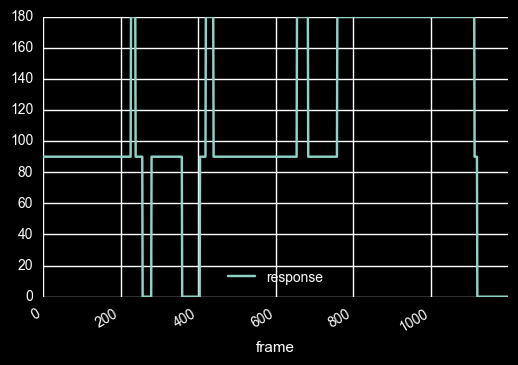

In [6]:
#g = sns.factorplot(x='frame', y='response', col='row', data=dsContDF, col_wrap=4, ci=None)
dsContDF[dsContDF.row==0].plot(x='frame', y='response', subplots=True)
#g = sns.factorplot(x=dsContX, y=dsContY, hue=dsContHue, col_wrap=1, size=3.5, ci=None)
#g.set_axis_labels('frameN','angle')
#plt.ylim(-0.1,1.1)

# Eye-tracking data

## Data import

In [7]:
subjEtPath = glob.glob(allSubjDirs[0] + '/' + 'data.asc')[0]
print subjEtPath
# Importing the data set the first time, with all the accompanying mess, for reading messages:
with open(subjEtPath) as f:
    mess = f.readlines()
# A cleaner import using cili to just read out the ET data:
from cili.util import *
from cili.cleanup import *
samps, events = load_eyelink_dataset(subjEtPath)
# Optional cleaning (probably not necessary):
#samps = interp_eyelink_blinks(samps, events, interp_fields=["pup_l"])
#samps = interp_zeros(samps, interp_fields=["pup_l"])
print samps.head(5)
print samps.columns
#print samps.ix[849896:849900]
# cili's native extraction of ranges for each event unfortunately doesn't work, although...
# ... I probably don't need it anyway:
from cili.extract import extract_event_ranges
#ranges = extract_event_ranges(samps, events, end_offset=1000)
# With the 'messy' data set, creating a lookup table with the trial numbers and time stamps:
trialStr = [s for s in mess if 'TRIALID' in s] # the string to look into
trialTS = map(int,[s[s.index('\t')+1:s.index(' T')] for s in trialStr]) # time stamp
trialN = map(int,[s[s.index('D ')+2:s.index('\n')] for s in trialStr]) # trial number
trialStartStr = [s for s in mess if 'START' in s]
trialStart = map(int,[s[s.index('\t')+1:s.index(' \t')] for s in trialStartStr])
trialEndStr = [s for s in mess if 'END' in s]
trialEnd = map(int,[s[s.index('\t')+1:s.index(' \t')] for s in trialEndStr])
# Collating the above into a data frame for lookup:
trials = pd.DataFrame({'trialN':trialN, 'trialTS':trialTS, 'trialStartTS':trialStart,
                      'trialEndTS':trialEnd})
trials['trialLength'] = trials['trialEndTS'] - trials['trialStartTS']
trials = trials[['trialN', 'trialTS', 'trialStartTS', 'trialEndTS', 'trialLength']]
#print np.max(trials['trialLength'])
print trials.head(5)

/Users/egor/Dropbox/Projects/md/data/dg_p0_crn-test_s1_r1_2017-01-09_1522/data.asc
          x_l    y_l   pup_l     x_r    y_r   pup_r
onset                                              
169236  977.9  330.0  7358.0  1067.3  330.0  7466.0
169238  978.0  330.0  7365.0  1067.3  330.0  7465.0
169240  978.1  330.0  7366.0  1067.7  330.0  7465.0
169242  978.3  330.0  7368.0  1068.0  330.0  7469.0
169244  978.3  330.0  7369.0  1068.1  330.0  7470.0
Index([u'x_l', u'y_l', u'pup_l', u'x_r', u'y_r', u'pup_r'], dtype='object')
   trialN  trialTS  trialStartTS  trialEndTS  trialLength
0       1   168679        169234      188783        19549
1       2   191663        192218      211777        19559


/Users/egor/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/cili/util.py:244: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[nums] = df[nums].convert_objects(convert_numeric=True)


In [8]:
# For each trial, take the appropriate chunk of em samps:
trialSamps = samps[((samps.index>=trials.trialStartTS[0]) & 
                    (samps.index<=trials.trialEndTS[0]))]
print trialSamps.head(5)
print trialSamps.shape

          x_l    y_l   pup_l     x_r    y_r   pup_r
onset                                              
169236  977.9  330.0  7358.0  1067.3  330.0  7466.0
169238  978.0  330.0  7365.0  1067.3  330.0  7465.0
169240  978.1  330.0  7366.0  1067.7  330.0  7465.0
169242  978.3  330.0  7368.0  1068.0  330.0  7469.0
169244  978.3  330.0  7369.0  1068.1  330.0  7470.0
(9774, 6)


array([<matplotlib.axes._subplots.AxesSubplot object at 0xdce35f0>], dtype=object)

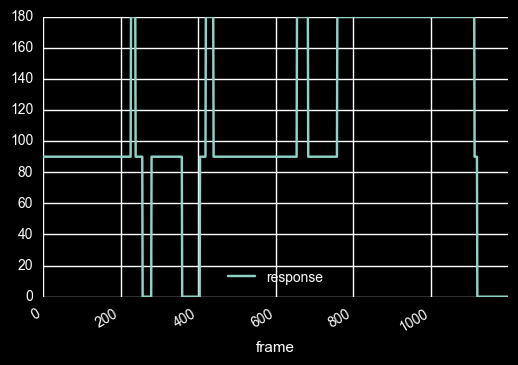

In [10]:
dsContDF[dsContDF.row==0].plot(x='frame', y='response', subplots=True)

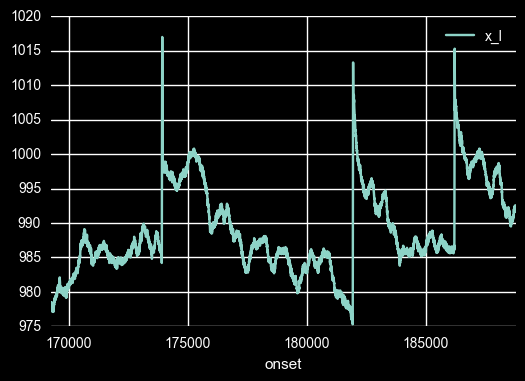

In [11]:
trialSamps.plot(y='x_l')

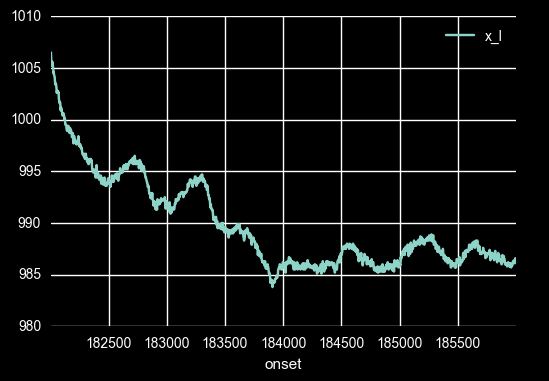

In [14]:
trialSamps[(trialSamps.index>182000) & (trialSamps.index<186000)].plot(y='x_l')

In [ ]:
# Creating my own ranges for each trial, with N number of samples:
#nSamples = 1500
#ranges = np.zeros((len(trialN),nSamples,6)) # 6 is for all six variables (L/R x,y,pup)
#print trialTS[0]
#print samps.ix[samps.ix>trialTS[0],0]
#print samps.index
#print samps.ix[int(trialTS[0]):int(trialTS[0])+600]
#print trialN
#trialStart = trialN # initiating a new variable to collect the 'actual' start
#trialEnd = trialN # the 'actual' end
#print trialN[-1] == 96
#for t in trialN:
    #print t
    # the actual start is the first data point following a trial time stamp:
    #trialStart[t-1] = samps.index[next(x[0] for x in enumerate(samps.index) if x[1] > trialTS[t-1])]
    #trialStart[t-1] = 
    #print t==trialN[-1]
    #if t != 96: # trialN[-1]: #WHY DOESN'T THIS WORK?!
        #print trialTS[t]
        #trialEnd[t-1] = samps.index[next(x[0] for x in enumerate(samps.index) if x[1] > trialTS[t])]
    #else:
        #trialEnd[t-1] = samps.index[-1]
    #end = trialStart[t-1]+nSamples
    #print end
    #ranges[t,:,:] = samps.ix[beg:end]
    #samps.ix[int(trialTS[int(t)-1]):int(trialTS[int(t)-1]+nSamples)]
#print trialStart
#print trialEnd